# Training Environment Sound Classification with Convolutional Neural Networks

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urbandata import k_fold_urban_sound, UrbanSoundDataSet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

device=device(type='cuda')


## Consts & Hyperparams

In [2]:
urban_root = Path('~/sound_datasets/urbansound8k').expanduser()
urban_metadata = urban_root / 'metadata/UrbanSound8K.csv'
urban_audio_path = urban_root / "audio/"

In [3]:
target_sample_rate = 22050
mel_kwargs = {
    'n_fft': 1024,
    'n_mels': 60
}

In [4]:
isShuffle = True
batch_size = 64
lr = 0.005
momentum = 0.9
EPOCHS=10

batch_print_threshold = 25

dry_run = False

## Network Setup

In [5]:
tmp_ds = UrbanSoundDataSet(urban_audio_path, ['fold5/100032-3-0-0.wav'], sample_rate=target_sample_rate, mel_kwargs=mel_kwargs)
X_shape = tmp_ds.getXShape()
print(f'Shape of model input, X: {X_shape}')

X_channels, X_rows, X_cols = X_shape

Shape of model input, X: torch.Size([2, 60, 173])


In [6]:
class SCCN(torch.nn.Module):
    '''The Simple CNN'''
    def __init__(self):
        super().__init__()
        
        # Recreating ESC paper, but with some modernization
        self.model = nn.Sequential(
            nn.Conv2d(X_channels, 30, 5),
            nn.BatchNorm2d(30),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(30, 60, kernel_size=5),
            nn.BatchNorm2d(60),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(60 * 12 * 40, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, X):
        return self.model(X)

## Training, with Cross Validation

In [7]:
folds = k_fold_urban_sound(urban_metadata, dry_run)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB

Summarizing folds:
-----------------------------------------------------------
Training set size for fold 1 : 7859
Training set info: 

Total samples: 7859
Class            | Frequency  | Percentage
----------------------------------------
engine_idling    | 904        | 11.50%
dog_bark         | 900        | 11.45%
children_playing | 900        | 11.45%
air_conditio

Training set size for fold 8 : 7926
Training set info: 

Total samples: 7926
Class            | Frequency  | Percentage
----------------------------------------
jackhammer       | 922        | 11.63%
engine_idling    | 912        | 11.51%
dog_bark         | 900        | 11.36%
children_playing | 900        | 11.36%
air_conditioner  | 900        | 11.36%
street_music     | 900        | 11.36%
drilling         | 900        | 11.36%
siren            | 849        | 10.71%
car_horn         | 399        | 5.03%
gun_shot         | 344        | 4.34%
----------------------------------------

Duration statistics: 
count    7926.000000
mean        3.610423
std         0.971687
min         0.054517
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: duration, dtype: float64
Validation set size for fold 8 : 806
Validation set info: 

Total samples: 806
Class            | Frequency  | Percentage
----------------------------------------
dog_bark         | 100   

In [8]:
model = SCCN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
loss_fn = torch.nn.CrossEntropyLoss()

In [9]:
def train_one_epoch(epoch, dl):
    model.train()
    
    running_loss = 0.
    running_batch_loss = 0.
    total = 0
    correct = 0
    avg_batch_loss = 0
    
    for batch_idx, batch in enumerate(dl):
        (Xs, ys) = batch['spectrogram'].to(device), batch['label'].to(device)
        
        optimizer.zero_grad()
        
        yhats = model(Xs)
        _, yhats_as_idx = torch.max(yhats, 1)
        
        loss = loss_fn(yhats, ys)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        running_batch_loss += loss.item()
        
        total += ys.size(0)
        correct += (ys == yhats_as_idx).sum().item()
        
#         print(f'Training ground truth {ys}')
#         print(f'Training predictions {yhats_as_idx}')
    
        if batch_idx % batch_print_threshold == batch_print_threshold-1:
            last_loss = running_loss / batch_print_threshold #batch loss
            avg_batch_loss = running_batch_loss / batch_print_threshold
            print(f'\tbatch {batch_idx+1} loss: {avg_batch_loss}')
            running_batch_loss = 0
            
    accuracy = correct / total 
    return running_loss / (batch_idx+1), accuracy

In [10]:
def validate(validation_dl):
    model.eval()
    
    running_vloss = 0.
    total = 0
    correct = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(validation_dl):
            (vXs, vys) = batch['spectrogram'].to(device), batch['label'].to(device)

            vyhats = model(vXs)
            _, vyhats_as_idx = torch.max(vyhats, 1)
            vloss = loss_fn(vyhats, vys)
            running_vloss += vloss
            
            total += vys.size(0)
            correct += (vys == vyhats_as_idx).sum().item()
#             print(f'Validation ground truth {vys}')
#             print(f'Validation redictions {vyhats_as_idx}')
    accuracy = correct/total
    return running_vloss.to('cpu') / (batch_idx+1), accuracy

In [11]:
def plot_fold_results(foldidx, losses_for_fold, acc_for_fold):
    plt.figure(figsize=(10, 6))
    train_losses, val_losses = zip(*losses_for_fold)
    train_acc, val_acc = zip(*acc_for_fold)
    print(train_acc)
    
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel(f'Losses for fold {foldidx}')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(train_acc, label='Training Acc')
    plt.plot(val_acc, label='Validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel(f'Accuracy for fold {foldidx}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

-----10-Fold Cross Validation-----
Fold 0:
	Size of train, val datasets: (7859, 873)
Epoch 1
	batch 25 loss: 2.2673805809020995
	batch 50 loss: 2.2244942665100096
	batch 75 loss: 2.2297704887390135
	batch 100 loss: 2.2079132270812987
Epoch 2
	batch 25 loss: 2.1772032356262208
	batch 50 loss: 2.149698143005371
	batch 75 loss: 2.148631362915039
	batch 100 loss: 2.133388376235962
Epoch 3
	batch 25 loss: 2.099179344177246
	batch 50 loss: 2.0739895486831665
	batch 75 loss: 2.0891970920562746
	batch 100 loss: 2.083925514221191
Epoch 4
	batch 25 loss: 2.046559295654297
	batch 50 loss: 2.0407172012329102
	batch 75 loss: 2.014662337303162
	batch 100 loss: 2.0258584308624266
Epoch 5
	batch 25 loss: 2.0190513467788698
	batch 50 loss: 2.0175724601745606
	batch 75 loss: 1.9941571617126466
	batch 100 loss: 1.9874611520767211
Epoch 6
	batch 25 loss: 1.9927820777893066
	batch 50 loss: 1.9845999240875245
	batch 75 loss: 1.980019392967224
	batch 100 loss: 1.9657901239395141
Epoch 7
	batch 25 loss: 1.974

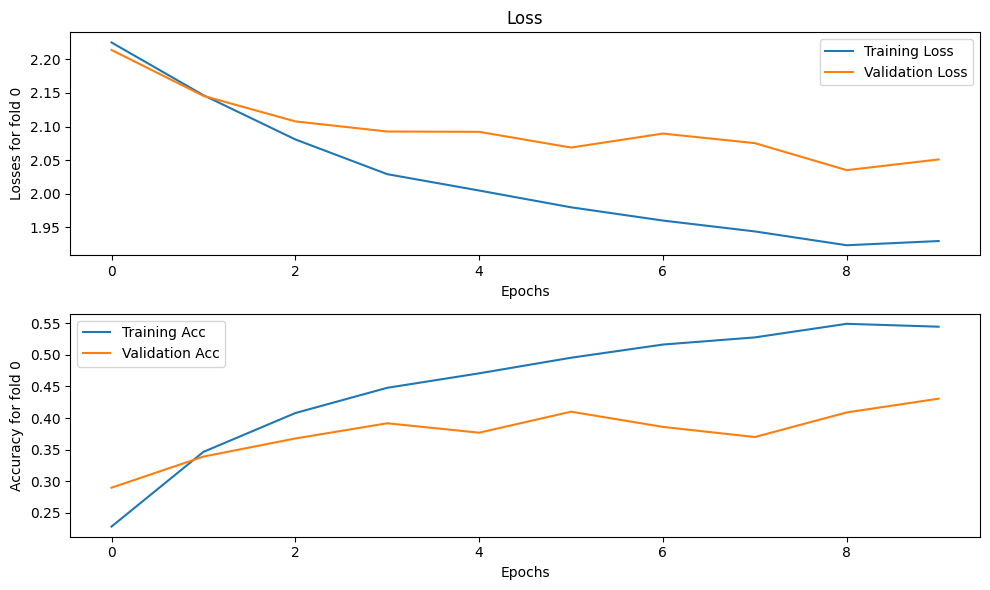

Fold 1:
	Size of train, val datasets: (7844, 888)
Epoch 1
	batch 25 loss: 1.941551342010498
	batch 50 loss: 1.915848774909973
	batch 75 loss: 1.938003544807434
	batch 100 loss: 1.9095726060867309
Epoch 2
	batch 25 loss: 1.8987075757980347
	batch 50 loss: 1.9080124473571778
	batch 75 loss: 1.9038295221328736
	batch 100 loss: 1.8843438243865966
Epoch 3
	batch 25 loss: 1.8762955856323242
	batch 50 loss: 1.8992994451522827
	batch 75 loss: 1.8875017690658569
	batch 100 loss: 1.8854947233200072
Epoch 4
	batch 25 loss: 1.8940006017684936
	batch 50 loss: 1.9052174806594848
	batch 75 loss: 1.9070595741271972
	batch 100 loss: 1.8698923444747926
Epoch 5
	batch 25 loss: 1.89086021900177
	batch 50 loss: 1.8655289506912232
	batch 75 loss: 1.8701204347610474
	batch 100 loss: 1.8641937065124512
Epoch 6
	batch 25 loss: 1.8959996795654297
	batch 50 loss: 1.8565531492233276
	batch 75 loss: 1.8717581510543824
	batch 100 loss: 1.8641687774658202
Epoch 7
	batch 25 loss: 1.857775592803955
	batch 50 loss: 1.8

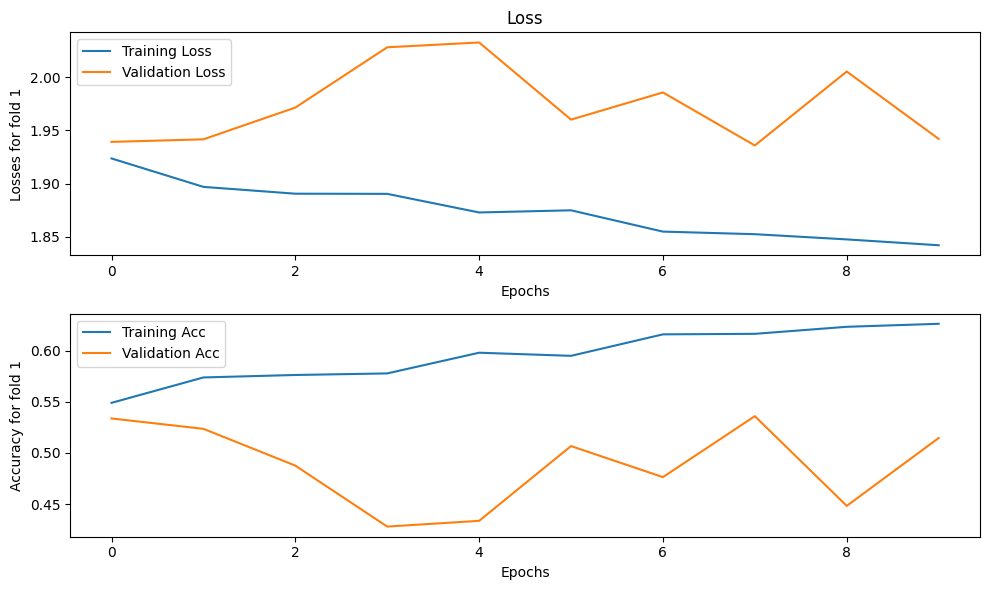

Fold 2:
	Size of train, val datasets: (7807, 925)
Epoch 1
	batch 25 loss: 1.8643153810501099
	batch 50 loss: 1.8454718160629273
	batch 75 loss: 1.836686978340149
	batch 100 loss: 1.8173760175704956
Epoch 2
	batch 25 loss: 1.8272788286209107
	batch 50 loss: 1.8405333948135376
	batch 75 loss: 1.835036072731018
	batch 100 loss: 1.840010976791382
Epoch 3
	batch 25 loss: 1.81662278175354
	batch 50 loss: 1.8022720861434935
	batch 75 loss: 1.8423998641967774
	batch 100 loss: 1.8324043321609498
Epoch 4
	batch 25 loss: 1.8250757265090942
	batch 50 loss: 1.8058500480651856
	batch 75 loss: 1.813159875869751
	batch 100 loss: 1.8200965023040772
Epoch 5
	batch 25 loss: 1.8041973638534545
	batch 50 loss: 1.8074920129776002
	batch 75 loss: 1.8141006803512574
	batch 100 loss: 1.8098999929428101
Epoch 6
	batch 25 loss: 1.789554810523987
	batch 50 loss: 1.7998413848876953
	batch 75 loss: 1.8045693016052247
	batch 100 loss: 1.7866091156005859
Epoch 7
	batch 25 loss: 1.8085919570922853
	batch 50 loss: 1.78

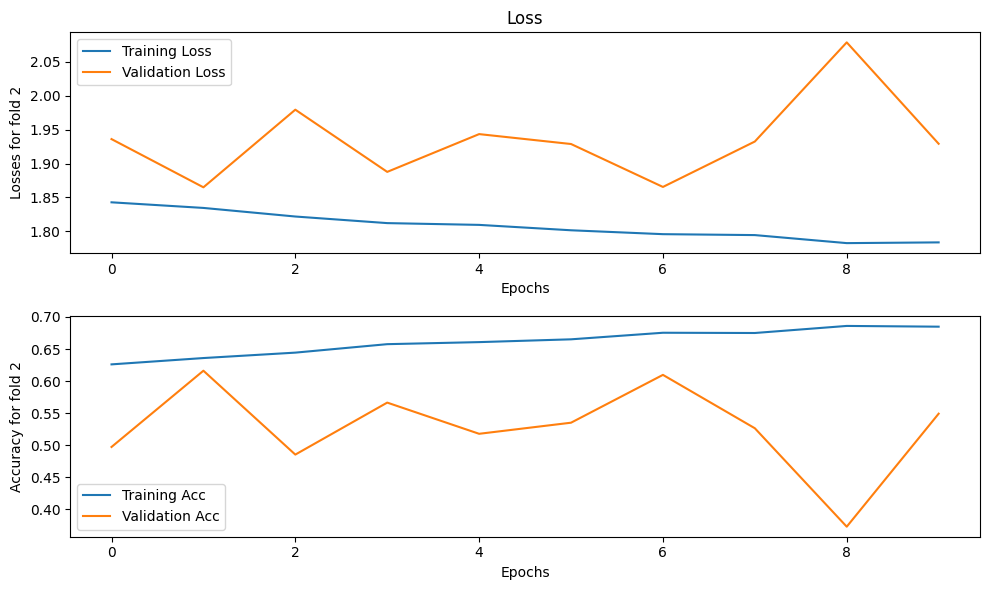

Fold 3:
	Size of train, val datasets: (7742, 990)
Epoch 1
	batch 25 loss: 1.8052902555465697
	batch 50 loss: 1.8133123207092285
	batch 75 loss: 1.7935183334350586
	batch 100 loss: 1.7974989748001098
Epoch 2
	batch 25 loss: 1.8008772039413452
	batch 50 loss: 1.7929723596572875
	batch 75 loss: 1.789421525001526
	batch 100 loss: 1.7844614839553834
Epoch 3
	batch 25 loss: 1.773790168762207
	batch 50 loss: 1.7747080945968627
	batch 75 loss: 1.7719374465942384
	batch 100 loss: 1.7813805866241454
Epoch 4
	batch 25 loss: 1.749353060722351
	batch 50 loss: 1.7827728986740112
	batch 75 loss: 1.7712384796142577
	batch 100 loss: 1.7979240465164184
Epoch 5
	batch 25 loss: 1.7578152418136597
	batch 50 loss: 1.7822131729125976
	batch 75 loss: 1.7941094207763673
	batch 100 loss: 1.772143898010254
Epoch 6
	batch 25 loss: 1.7540882205963135
	batch 50 loss: 1.7750060749053955
	batch 75 loss: 1.7704857397079468
	batch 100 loss: 1.756445369720459
Epoch 7
	batch 25 loss: 1.7469974184036254
	batch 50 loss: 1.

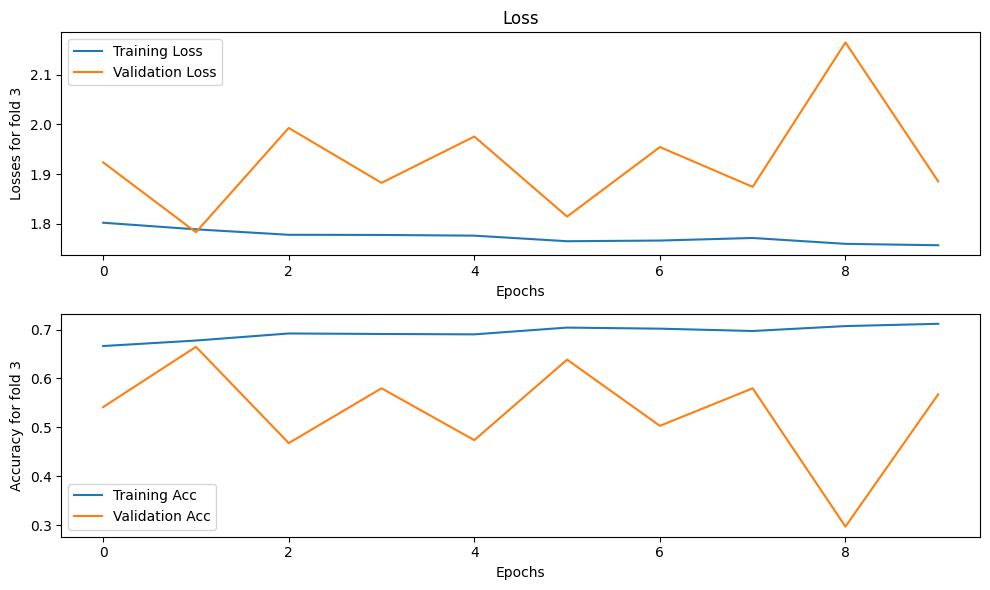

Fold 4:
	Size of train, val datasets: (7796, 936)
Epoch 1
	batch 25 loss: 1.7478500318527221
	batch 50 loss: 1.7476500654220581
	batch 75 loss: 1.7563870763778686
	batch 100 loss: 1.754484338760376
Epoch 2
	batch 25 loss: 1.7575008058547974
	batch 50 loss: 1.7586955738067627
	batch 75 loss: 1.742143521308899
	batch 100 loss: 1.739132342338562
Epoch 3
	batch 25 loss: 1.7516913032531738
	batch 50 loss: 1.7340347957611084
	batch 75 loss: 1.7574498796463012
	batch 100 loss: 1.7397876644134522
Epoch 4
	batch 25 loss: 1.7510040521621704
	batch 50 loss: 1.759918098449707
	batch 75 loss: 1.7461957740783691
	batch 100 loss: 1.753857879638672
Epoch 5
	batch 25 loss: 1.7604667377471923
	batch 50 loss: 1.7468138599395753
	batch 75 loss: 1.7424661016464233
	batch 100 loss: 1.7471692609786986
Epoch 6
	batch 25 loss: 1.742654414176941
	batch 50 loss: 1.742601523399353
	batch 75 loss: 1.7231507778167725
	batch 100 loss: 1.7404304647445679
Epoch 7
	batch 25 loss: 1.745825128555298
	batch 50 loss: 1.725

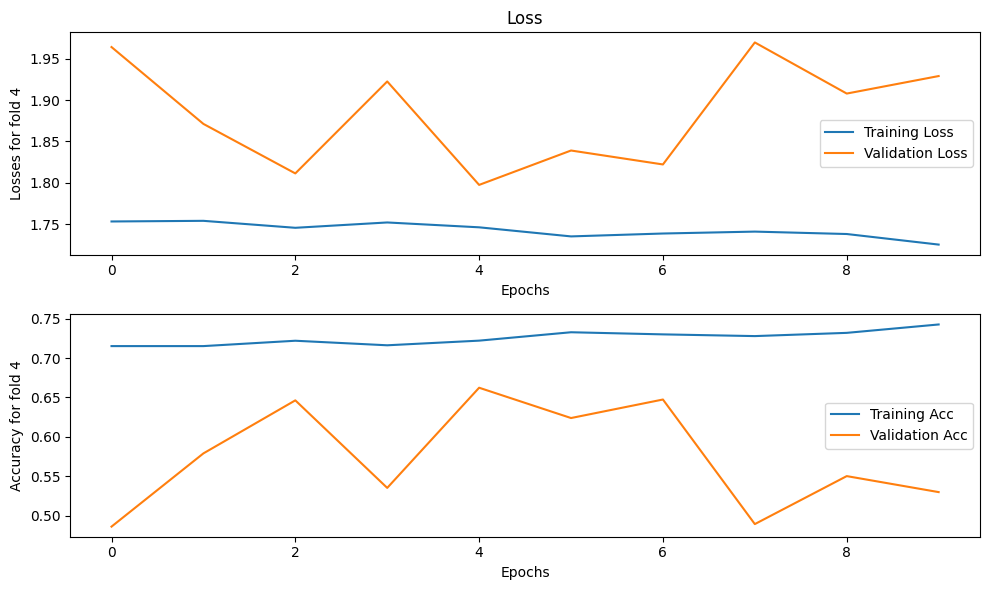

Fold 5:
	Size of train, val datasets: (7909, 823)
Epoch 1
	batch 25 loss: 1.7251593255996704
	batch 50 loss: 1.7299100732803345
	batch 75 loss: 1.74118079662323
	batch 100 loss: 1.7327487468719482
Epoch 2
	batch 25 loss: 1.7418700742721558
	batch 50 loss: 1.7390189695358276
	batch 75 loss: 1.722513461112976
	batch 100 loss: 1.7322394227981568
Epoch 3
	batch 25 loss: 1.7261046600341796
	batch 50 loss: 1.7249599885940552
	batch 75 loss: 1.735676989555359
	batch 100 loss: 1.7194396781921386
Epoch 4
	batch 25 loss: 1.7220845985412598
	batch 50 loss: 1.7167161893844605
	batch 75 loss: 1.7322896146774291
	batch 100 loss: 1.7311409997940064
Epoch 5
	batch 25 loss: 1.7314769315719605
	batch 50 loss: 1.7165382051467895
	batch 75 loss: 1.7279481458663941
	batch 100 loss: 1.711257028579712
Epoch 6
	batch 25 loss: 1.7413087224960326
	batch 50 loss: 1.7200255584716797
	batch 75 loss: 1.715569543838501
	batch 100 loss: 1.7239838600158692
Epoch 7
	batch 25 loss: 1.713294005393982
	batch 50 loss: 1.71

In [ ]:
print(f'-----{len(folds)}-Fold Cross Validation-----')
for fold_idx, fold_bundle in enumerate(folds):
    print(f"Fold {fold_idx}:")
    train_ds = UrbanSoundDataSet(urban_audio_path, fold_bundle['train'], sample_rate=target_sample_rate, mel_kwargs=mel_kwargs)
    validation_ds = UrbanSoundDataSet(urban_audio_path, fold_bundle['validation'], sample_rate=target_sample_rate, mel_kwargs=mel_kwargs)
    print(f"\tSize of train, val datasets: {(len(train_ds), len(validation_ds))}")
    
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=isShuffle)
    validation_dl = DataLoader(validation_ds, batch_size=batch_size, shuffle=isShuffle)
    
    losses_for_fold, accs_for_fold = [], []
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}')
        
        avg_loss, acc = train_one_epoch(epoch, train_dl)
        avg_vloss, vacc = validate(validation_dl)
        
        losses_for_fold.append((avg_loss, avg_vloss))
        accs_for_fold.append((acc, vacc))
#         print(f'LOSS train {avg_loss} val {avg_vloss}')
        
    plot_fold_results(fold_idx, losses_for_fold, accs_for_fold)
